In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import yaml

from pathlib import Path


In [3]:
# select the experiment for which you want to analyse data
experiment_id = "exp2_64edc58_20251008_193554"

### Load Data

In [4]:
# set the paths
current_folder = globals()['_dh'][0]
results_path = os.path.join(current_folder,f'results/{experiment_id}')

# read the number of simulations from the config file
with open(os.path.join(results_path, 'config_used.yaml'), "r") as f:
    config = yaml.safe_load(f)
N_SIMS = config['experiment']['n_sims']

# read the results data
iteration_histories = [pd.read_csv(os.path.join(results_path, f'sims/data/iteration_history_{sim+1}.csv'), index_col=0)
                                 for sim in range(N_SIMS)]
agents_histories = [pd.read_csv(os.path.join(results_path, f'sims/data/agent_histories_{sim+1}.csv'), index_col=0)
                    for sim in range(N_SIMS)]

# combine multiple simulations into single dataframes
df_data_all = pd.concat(
    [df.assign(sim=i+1) for i, df in enumerate(iteration_histories)],
    ignore_index=True
)
df_data_agents_all = pd.concat(
    [df.assign(sim=i+1) for i, df in enumerate(agents_histories)],
    ignore_index=True
)


In [5]:
df_data_all

,round,iteration,price,announcement,transaction,announcement_type,announcing_agent_id,announcing_agent_reservation_price,responding_agent_id,responding_agent_reservation_price,sim
0,1,1,2.72,True,True,sell,8,2.72,10,3.20,1
1,1,2,2.72,True,True,sell,5,2.00,8,2.72,1
2,1,3,1.04,True,False,buy,1,1.04,2,1.28,1
3,1,3,1.04,True,False,buy,1,1.04,7,2.48,1
4,1,3,1.04,True,False,buy,1,1.04,4,1.76,1
...,...,...,...,...,...,...,...,...,...,...,...
2958,7,10,1.04,True,False,buy,1,1.04,4,1.76,10
2959,7,10,2.24,True,False,sell,4,1.76,1,1.04,10
2960,7,10,2.24,True,False,sell,4,1.76,0,0.80,10
2961,7,10,1.28,True,False,sell,2,1.28,1,1.04,10


### Plot Transaction Prices

In [6]:
df_transactions_all = df_data_all.loc[df_data_all['transaction']==True].reset_index()
df_transactions_all

,index,round,iteration,price,announcement,transaction,announcement_type,announcing_agent_id,announcing_agent_reservation_price,responding_agent_id,responding_agent_reservation_price,sim
0,0,1,1,2.72,True,True,sell,8,2.72,10,3.20,1
1,1,1,2,2.72,True,True,sell,5,2.00,8,2.72,1
2,7,1,3,1.04,True,True,buy,1,1.04,1,1.04,1
3,8,1,4,1.76,True,True,sell,4,1.76,10,3.20,1
4,10,1,5,2.72,True,True,buy,9,2.96,2,1.28,1
...,...,...,...,...,...,...,...,...,...,...,...,...
639,2941,7,5,1.28,True,True,buy,2,1.28,1,1.04,10
640,2946,7,6,1.52,True,True,buy,3,1.52,2,1.28,10
641,2947,7,7,2.24,True,True,sell,6,2.24,6,2.24,10
642,2948,7,8,2.48,True,True,sell,0,0.80,10,3.20,10


In [8]:
sim_round_avg = df_transactions_all.groupby(['sim', 'round'])['price'].agg(['mean', 'std', 'count']).reset_index()
sim_round_avg

,sim,round,mean,std,count
0,1,1,2.120000,0.622254,10
1,1,2,2.300000,0.333295,8
2,1,3,1.973333,0.662118,9
3,1,4,2.160000,0.611882,9
4,1,5,2.346667,0.538145,9
...,...,...,...,...,...
65,10,3,1.946667,0.707672,9
66,10,4,2.120000,0.528934,8
67,10,5,1.736000,0.624308,10
68,10,6,2.060000,0.650977,8


In [9]:
round_avg = sim_round_avg.groupby('round')['mean'].mean().reset_index()
round_avg

,round,mean
0,1,2.160500
1,2,2.224898
2,3,2.138600
3,4,2.190700
4,5,2.047467
5,6,2.215800
6,7,2.145222


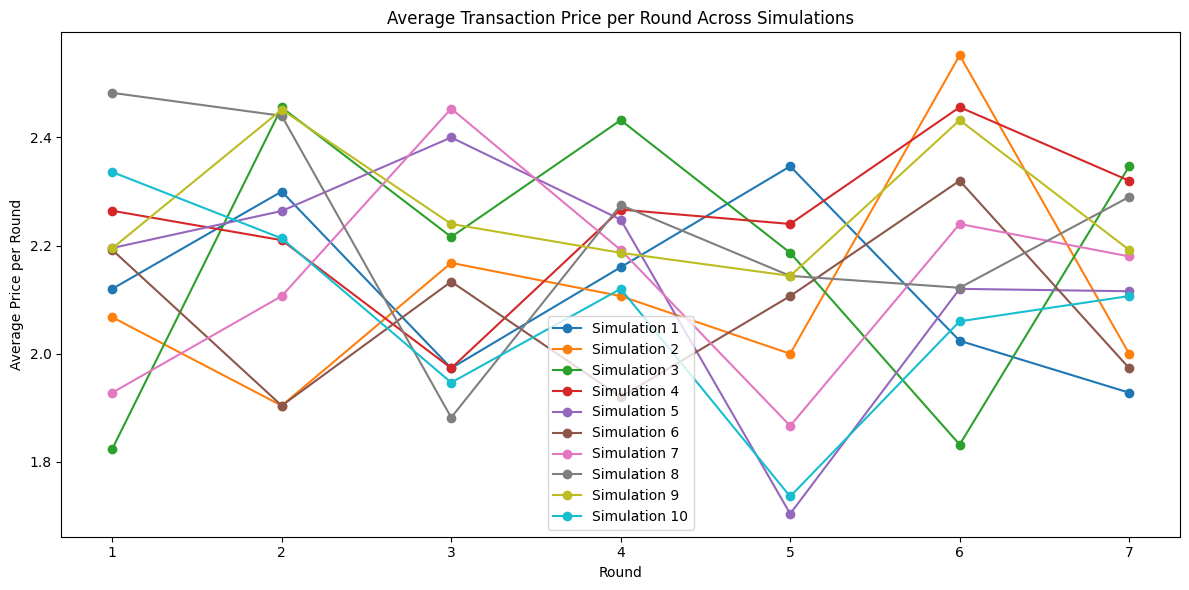

In [20]:
df_plot = sim_round_avg.pivot_table(index='round', columns='sim', values='mean')

plt.figure(figsize=(12,6))
for sim_id in range(1, N_SIMS+1):
    plt.plot(df_plot.index, df_plot[sim_id], marker='o', label=f'Simulation {sim_id}')

# format and plot
plt.xlabel('Round')
plt.ylabel('Average Price per Round')
plt.title('Average Transaction Price per Round Across Simulations')
plt.legend()
plt.tight_layout()
plt.show()


In [11]:
sim_round_avg

,sim,round,mean,std,count
0,1,1,2.120000,0.622254,10
1,1,2,2.300000,0.333295,8
2,1,3,1.973333,0.662118,9
3,1,4,2.160000,0.611882,9
4,1,5,2.346667,0.538145,9
...,...,...,...,...,...
65,10,3,1.946667,0.707672,9
66,10,4,2.120000,0.528934,8
67,10,5,1.736000,0.624308,10
68,10,6,2.060000,0.650977,8


In [12]:
round_stats = sim_round_avg.groupby('round')['mean'].agg(['mean', 'std']).reset_index()
round_stats
# STD seems falling --> maybe we will get more convergence if we have more rounds???

,round,mean,std
0,1,2.160500,0.190402
1,2,2.224898,0.205005
2,3,2.138600,0.194896
3,4,2.190700,0.133619
4,5,2.047467,0.215518
5,6,2.215800,0.224908
6,7,2.145222,0.147450


/tmp/ipykernel_14426/1487314843.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


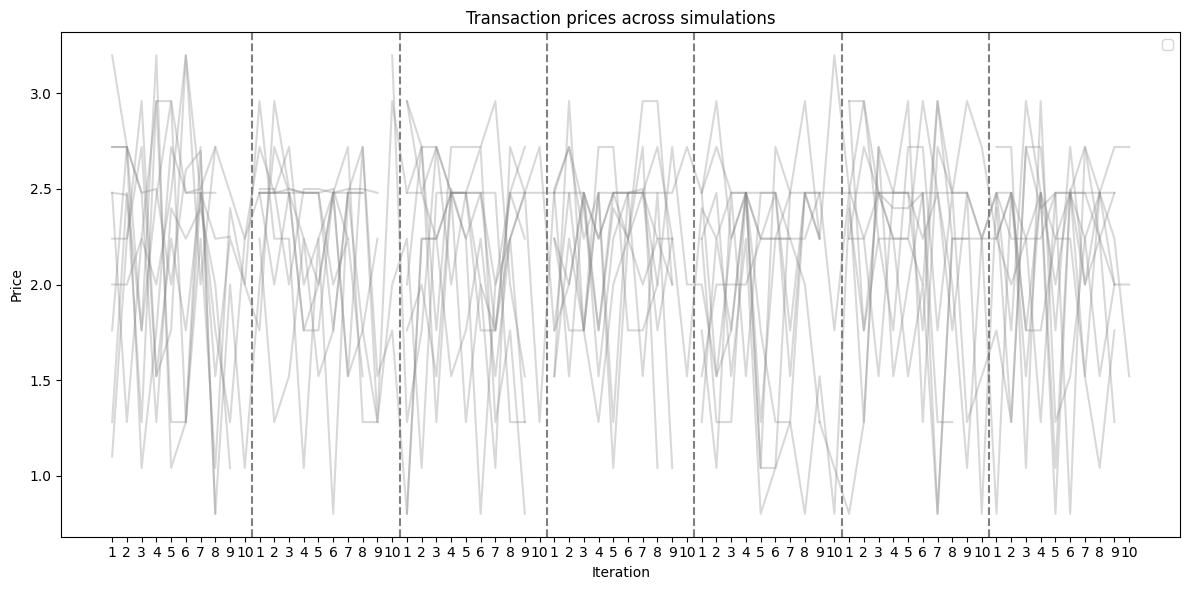

In [13]:
df_plot = df_transactions_all.copy()

# Create an empty DataFrame with all unique (round, iteration) as index
rounds = df_plot['round'].unique()
iterations = df_plot['iteration'].unique()
sims = df_plot['sim'].unique()

# Create full multi-index
multi_index = pd.MultiIndex.from_product([rounds, iterations], names=['round','iteration'])
aligned_df = pd.DataFrame(index=multi_index)

# Fill each simulation as a separate column
for sim_id in sims:
    sim_prices = df_plot[df_plot['sim']==sim_id].set_index(['round','iteration'])['price']
    aligned_df[f"sim_{sim_id}"] = sim_prices

aligned_df = aligned_df.reset_index()
aligned_df

# plot all simulations
plt.figure(figsize=(12,6))
for col in aligned_df.columns:
    if col.startswith('sim_'):
        plt.plot(aligned_df.index, aligned_df[col], color='gray', alpha=0.3)

# Highlight the last iteration in each round
last_indices_in_round = aligned_df.groupby('round')['iteration'].apply(lambda g: g.index.max())
for x in last_indices_in_round[:-1]:
    plt.axvline(x=x+0.5, color='grey', linestyle='--', linewidth=1.5)

# ensure x-ticks correspond to iterations
plt.xticks(ticks=aligned_df.index, labels=aligned_df['iteration'], rotation=0)

# format and plot
plt.xlabel('Iteration')
plt.ylabel('Price')
plt.title('Transaction prices across simulations')
plt.legend()
plt.tight_layout()
plt.show()

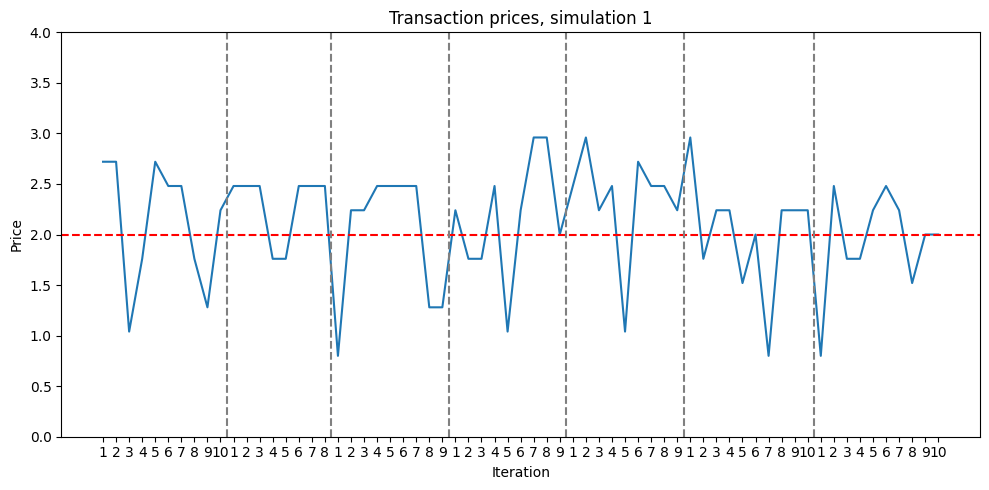

In [14]:
# plot the transaction prices per simulation
sim = 1 # choose the simulation to plot
df_data = df_data_all.loc[df_data_all['sim']==sim].copy()
df_plot = df_data.loc[df_data['transaction']==True].reset_index()
plt.figure(figsize=(10, 5))
sns.lineplot(x=df_plot.index, y='price', markers='x', 
                data=df_plot)
plt.axhline(y=2, color='red', linestyle='--')
last_indices_in_round = df_plot.groupby('round')['iteration'].apply(lambda g: g.index.max())
for x in last_indices_in_round[:-1]:
    plt.axvline(x=x+0.5, color='grey', linestyle='--', linewidth=1.5)
plt.xticks(ticks=df_plot.index, labels=df_plot['iteration'], rotation=0)
plt.title('Transaction prices, simulation '+str(sim))
plt.xlabel('Iteration')
plt.ylabel('Price')
plt.tight_layout()
plt.ylim(0, 4)
plt.show()

In [18]:
df_transactions_all

,index,round,iteration,price,announcement,transaction,announcement_type,announcing_agent_id,announcing_agent_reservation_price,responding_agent_id,responding_agent_reservation_price,sim
0,0,1,1,2.72,True,True,sell,8,2.72,10,3.20,1
1,1,1,2,2.72,True,True,sell,5,2.00,8,2.72,1
2,7,1,3,1.04,True,True,buy,1,1.04,1,1.04,1
3,8,1,4,1.76,True,True,sell,4,1.76,10,3.20,1
4,10,1,5,2.72,True,True,buy,9,2.96,2,1.28,1
...,...,...,...,...,...,...,...,...,...,...,...,...
639,2941,7,5,1.28,True,True,buy,2,1.28,1,1.04,10
640,2946,7,6,1.52,True,True,buy,3,1.52,2,1.28,10
641,2947,7,7,2.24,True,True,sell,6,2.24,6,2.24,10
642,2948,7,8,2.48,True,True,sell,0,0.80,10,3.20,10


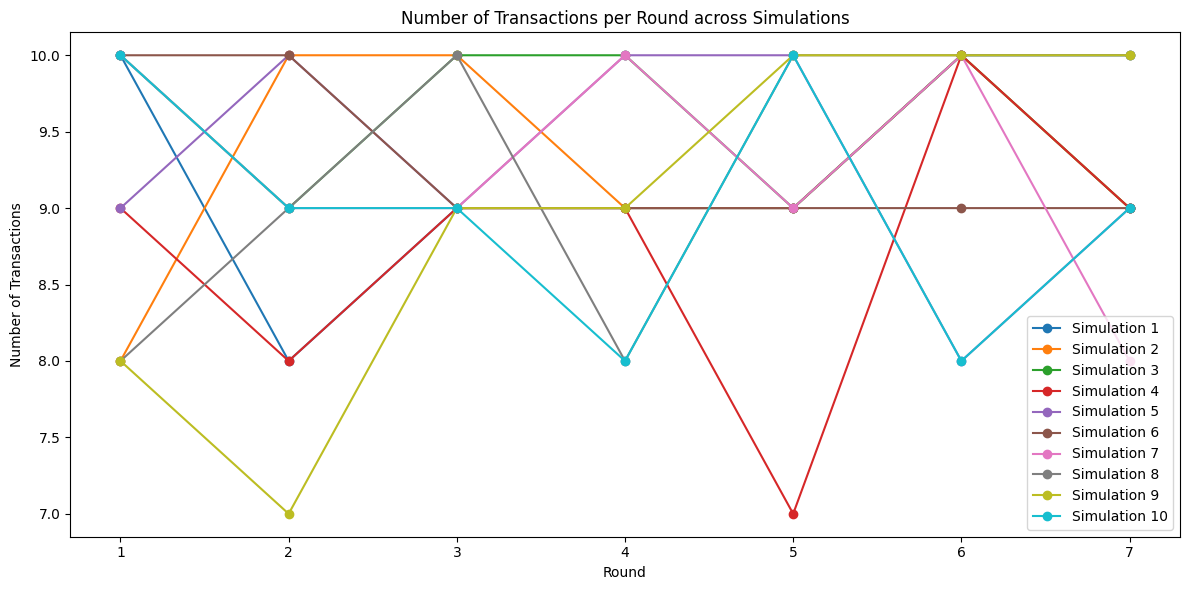

In [24]:
# plot the average number of transactions per round
df_plot = df_transactions_all.groupby(['sim', 'round'])['price'].count().reset_index()
df_plot = df_plot.rename(columns={'price': 'transactions'})
df_plot = df_plot.pivot_table(index='round', columns='sim', values='transactions')

plt.figure(figsize=(12,6))
for sim_id in range(1, N_SIMS+1):
    plt.plot(df_plot.index, df_plot[sim_id], marker='o', 
             label=f'Simulation {sim_id}')

# format and plot
plt.xlabel('Round')
plt.ylabel('Number of Transactions')
plt.title('Number of Transactions per Round across Simulations')
plt.legend()
plt.tight_layout()
plt.show()

### Analyse Profits

In [25]:
df_data_agents_all

,round,iteration,action,price,outcome,id,reservation_price,type,sim
0,2,1,respond,2.72,rejected,0,0.8,buyer,1
1,2,5,respond,1.76,rejected,0,0.8,buyer,1
2,2,6,announce,0.80,rejected,0,0.8,buyer,1
3,2,7,respond,2.72,rejected,0,0.8,buyer,1
4,2,7,announce,0.80,rejected,0,0.8,buyer,1
...,...,...,...,...,...,...,...,...,...
4124,6,2,respond,1.28,rejected,10,3.2,seller,10
4125,6,3,announce,3.20,rejected,10,3.2,seller,10
4126,6,4,respond,1.76,rejected,10,3.2,seller,10
4127,6,4,respond,2.48,rejected,10,3.2,seller,10


In [26]:
# construct an implied profit column for each agents action
df_data_agents_all['implied_profit'] = np.where(
    df_data_agents_all['type'] == 'buyer',
    df_data_agents_all['reservation_price'] - df_data_agents_all['price'],  # buyer profit
    df_data_agents_all['price'] - df_data_agents_all['reservation_price']   # seller profit
)

In [27]:
df_profits_realized = df_data_agents_all.loc[df_data_agents_all['outcome']=="accepted"].sort_values(by=["sim", "round", "iteration"]).reset_index(drop=True)

df_profits_realized

,round,iteration,action,price,outcome,id,reservation_price,type,sim,implied_profit
0,1,1,respond,2.72,accepted,10,3.20,buyer,1,0.48
1,1,1,announce,2.72,accepted,8,2.72,seller,1,0.00
2,1,2,respond,2.72,accepted,8,2.72,buyer,1,0.00
3,1,2,announce,2.72,accepted,5,2.00,seller,1,0.72
4,1,3,announce,1.04,accepted,1,1.04,buyer,1,0.00
...,...,...,...,...,...,...,...,...,...,...
1283,7,7,announce,2.24,accepted,6,2.24,seller,10,0.00
1284,7,8,respond,2.48,accepted,10,3.20,buyer,10,0.72
1285,7,8,announce,2.48,accepted,0,0.80,seller,10,1.68
1286,7,9,respond,2.00,accepted,6,2.24,buyer,10,0.24


In [28]:
# filter only the accepted offers
df_profits_realized = df_data_agents_all.loc[df_data_agents_all['outcome']=="accepted"].sort_values(by=["sim", "round", "iteration"]).reset_index(drop=True)

# Calculate profits for buyers and sellers per iteration
df = df_profits_realized.copy()
result = df.pivot_table(
    index=['sim', 'round', 'iteration'],
    columns='type',
    values='implied_profit',
    aggfunc='first'
).reset_index()

# Rename the columns for clarity
result.columns.name = None
result = result.rename(columns={
    'buyer': 'buyer_profit',
    'seller': 'seller_profit'
})

# Add the announcer column
announcer = df[df['action'] == 'announce'].set_index(['sim', 'round', 'iteration'])['type']
df_profits = result.merge(
    announcer.rename('announcer'),
    left_on=['sim', 'round', 'iteration'],
    right_index=True,
    how='left'
)

print(df_profits)

     sim  round  iteration  buyer_profit  seller_profit announcer
0      1      1          1          0.48           0.00    seller
1      1      1          2          0.00           0.72    seller
2      1      1          3          0.00           0.00     buyer
3      1      1          4          1.44           0.00    seller
4      1      1          5          0.24           1.44     buyer
..   ...    ...        ...           ...            ...       ...
639   10      7          5          0.00           0.24     buyer
640   10      7          6          0.00           0.24     buyer
641   10      7          7          0.00           0.00    seller
642   10      7          8          0.72           1.68    seller
643   10      7          9          0.24           0.00    seller

[644 rows x 6 columns]


In [29]:
# check for negative profits
df_profits.loc[(df_profits['seller_profit']<0) | (df_profits['buyer_profit']<0)]

,sim,round,iteration,buyer_profit,seller_profit,announcer
112,2,6,2,0.00,-0.24,seller
285,5,3,9,0.00,-0.24,buyer
320,5,7,7,0.00,-0.24,buyer
530,9,2,5,-0.24,0.72,seller


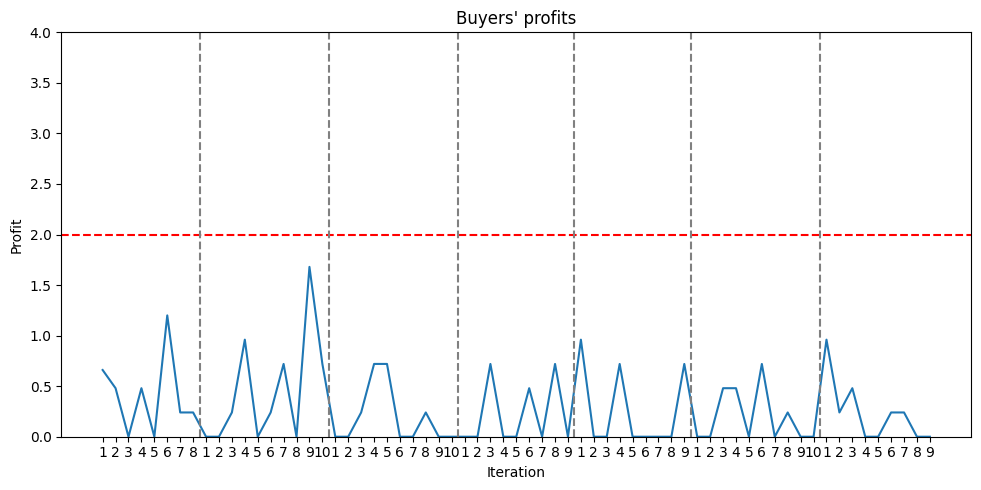

In [30]:
# plot the buyer profits in a single simulation
sim = 2 # choose the simulation to plot
df_plot = df_profits.loc[df_profits['sim']==sim].copy()
plt.figure(figsize=(10, 5))
sns.lineplot(x=df_plot.index, y='buyer_profit', markers='x', 
                data=df_plot)
plt.axhline(y=2, color='red', linestyle='--')
last_indices_in_round = df_plot.groupby('round')['iteration'].apply(lambda g: g.index.max())
for x in last_indices_in_round[:-1]:
    plt.axvline(x=x+0.5, color='grey', linestyle='--', linewidth=1.5)
plt.xticks(ticks=df_plot.index, labels=df_plot['iteration'], rotation=0)
plt.title("Buyers' profits")
plt.xlabel('Iteration')
plt.ylabel('Profit')
plt.tight_layout()
plt.ylim(0, 4)
plt.show()

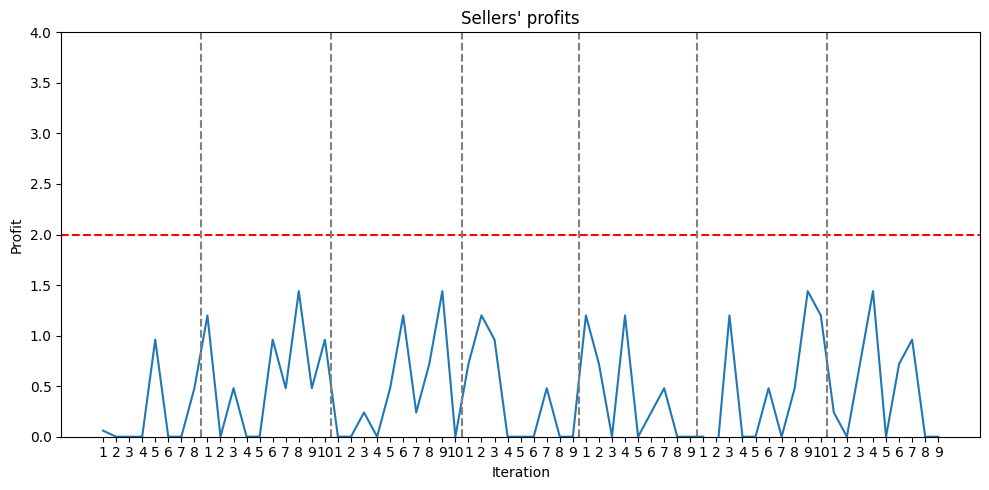

In [31]:
# plot the seller's profits in a single simulation
sim = 2 # choose the simulation to plot
df_plot = df_profits.loc[df_profits['sim']==sim].copy()
plt.figure(figsize=(10, 5))
sns.lineplot(x=df_plot.index, y='seller_profit', markers='x', 
                data=df_plot)
plt.axhline(y=2, color='red', linestyle='--')
last_indices_in_round = df_plot.groupby('round')['iteration'].apply(lambda g: g.index.max())
for x in last_indices_in_round[:-1]:
    plt.axvline(x=x+0.5, color='grey', linestyle='--', linewidth=1.5)
plt.xticks(ticks=df_plot.index, labels=df_plot['iteration'], rotation=0)
plt.title("Sellers' profits")
plt.xlabel('Iteration')
plt.ylabel('Profit')
plt.tight_layout()
plt.ylim(0, 4)
plt.show()

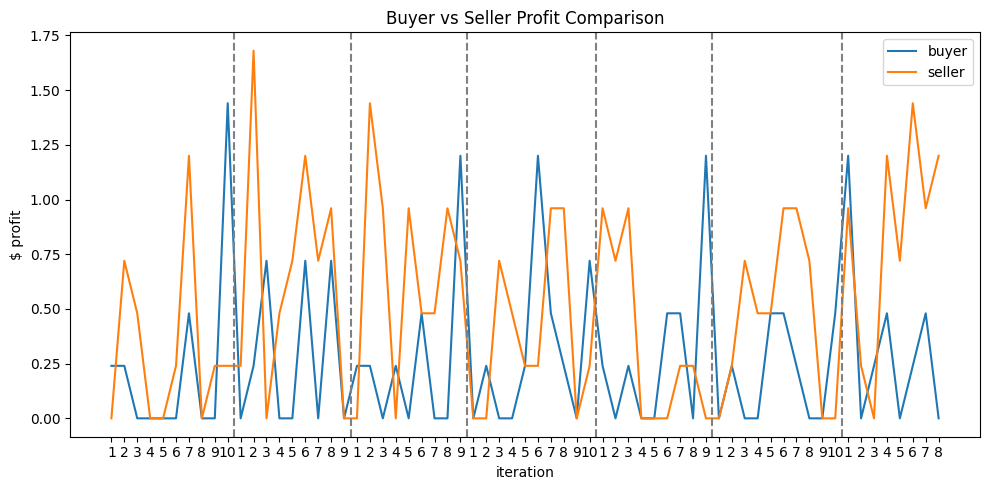

In [32]:
# plot buyer vs seller profits in a single simulation
sim = 7 # choose the simulation to plot
df_plot = df_profits.loc[df_profits['sim']==sim].copy()
plt.figure(figsize=(10, 5))
plt.plot(df_plot.index, df_plot['buyer_profit'], label=f'buyer')
plt.plot(df_plot.index, df_plot['seller_profit'], label=f'seller')
last_indices_in_round = df_plot.groupby('round')['iteration'].apply(lambda g: g.index.max())
for x in last_indices_in_round[:-1]:
    plt.axvline(x=x+0.5, color='grey', linestyle='--', linewidth=1.5)
plt.xticks(ticks=df_plot.index, labels=df_plot['iteration'], rotation=0)
plt.title(f"Buyer vs Seller Profit Comparison")
plt.ylabel("$ profit")
plt.xlabel("iteration")
plt.legend()
plt.tight_layout()
plt.show()

In [33]:
# calculate announcer vs responder profits
df_profits['announcer_profit'] = np.where(
    df_profits['announcer'] == 'buyer',
    df_profits['buyer_profit'],
    df_profits['seller_profit']
)
df_profits['responder_profit'] = np.where(
    df_profits['announcer'] == 'seller',
    df_profits['buyer_profit'],
    df_profits['seller_profit']
)
df_profits

,sim,round,iteration,buyer_profit,seller_profit,announcer,announcer_profit,responder_profit
0,1,1,1,0.48,0.00,seller,0.00,0.48
1,1,1,2,0.00,0.72,seller,0.72,0.00
2,1,1,3,0.00,0.00,buyer,0.00,0.00
3,1,1,4,1.44,0.00,seller,0.00,1.44
4,1,1,5,0.24,1.44,buyer,0.24,1.44
...,...,...,...,...,...,...,...,...
639,10,7,5,0.00,0.24,buyer,0.00,0.24
640,10,7,6,0.00,0.24,buyer,0.00,0.24
641,10,7,7,0.00,0.00,seller,0.00,0.00
642,10,7,8,0.72,1.68,seller,1.68,0.72


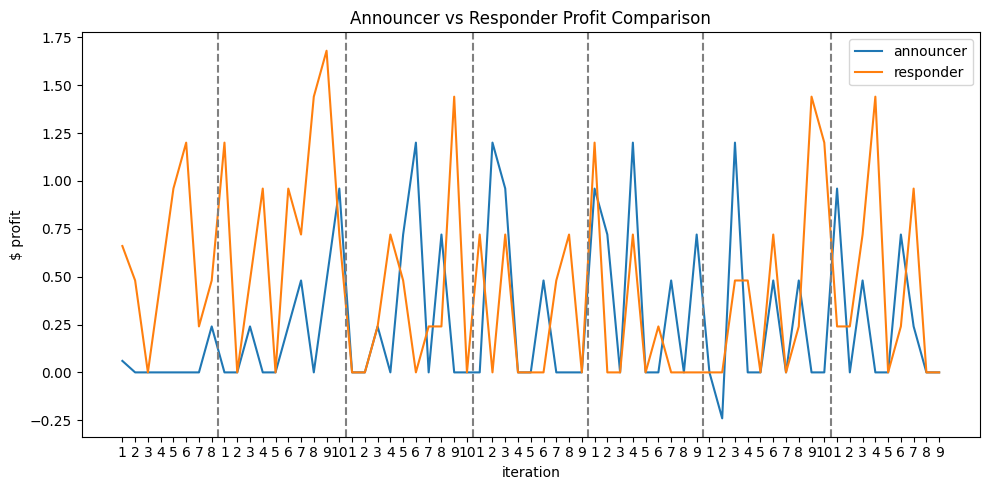

In [34]:
# plot announcer vs responders profits
sim = 2 # choose the simulation to plot
df_plot = df_profits.loc[df_profits['sim']==sim].copy()
plt.figure(figsize=(10, 5))
plt.plot(df_plot.index, df_plot['announcer_profit'], label=f'announcer')
plt.plot(df_plot.index, df_plot['responder_profit'], label=f'responder')
last_indices_in_round = df_plot.groupby('round')['iteration'].apply(lambda g: g.index.max())
for x in last_indices_in_round[:-1]:
    plt.axvline(x=x+0.5, color='grey', linestyle='--', linewidth=1.5)
plt.xticks(ticks=df_plot.index, labels=df_plot['iteration'], rotation=0)
plt.title(f"Announcer vs Responder Profit Comparison")
plt.ylabel("$ profit")
plt.xlabel("iteration")
plt.legend()
plt.tight_layout()
plt.show()

In [35]:
n_transactions = len(df_data_all.loc[df_data_all['transaction']==True])
assert n_transactions == len(df_profits)
print(f"Number of successful transactions: {n_transactions}")

Number of successful transactions: 644


In [36]:
df_profits['announcer'] == "buyer"

0      False
1      False
2       True
3      False
4       True
       ...  
639     True
640     True
641    False
642    False
643    False
Name: announcer, Length: 644, dtype: bool

In [37]:

def compute_stats(df):
    n_transactions = len(df)
    
    announcer_zero = (df['announcer_profit'] == 0).sum() / n_transactions
    responder_zero = (df['responder_profit'] == 0).sum() / n_transactions
    avg_announcer = df['announcer_profit'].mean()
    avg_responder = df['responder_profit'].mean()

    # Define masks for buyers/sellers in this sim
    ann_buyer_mask = df['announcer'] == "buyer"
    ann_seller_mask = df['announcer'] == "seller"

    # Per-announcer-type denominators (only transactions where announcer is that type)
    n_ann_buyer = ann_buyer_mask.sum()
    n_ann_seller = ann_seller_mask.sum()
    
    # By type
    announcer_zero_buy = ((df['announcer_profit']==0) & ann_buyer_mask.loc[df.index]).sum() / n_ann_buyer
    announcer_zero_sell = ((df['announcer_profit']==0) & ann_seller_mask.loc[df.index]).sum() / n_ann_seller
    avg_announcer_buy = df.loc[ann_buyer_mask, 'announcer_profit'].mean()
    avg_announcer_sell = df.loc[ann_seller_mask, 'announcer_profit'].mean()
    
    responder_zero_buy = ((df['responder_profit']==0) & ann_seller_mask.loc[df.index]).sum() / n_ann_seller
    responder_zero_sell = ((df['responder_profit']==0) & ann_buyer_mask.loc[df.index]).sum() / n_ann_buyer
    avg_responder_buy = df.loc[ann_seller_mask, 'responder_profit'].mean()
    avg_responder_sell = df.loc[ann_buyer_mask, 'responder_profit'].mean()
    
    share_buy_announcer = ann_buyer_mask.loc[df.index].sum() / n_transactions
    share_sell_announcer = ann_seller_mask.loc[df.index].sum() / n_transactions
    
    return pd.Series({
        'zero_profit_announcers': announcer_zero,
        'zero_profit_responders': responder_zero,
        'avg_profit_announcers': avg_announcer,
        'avg_profit_responders': avg_responder,
        'zero_profit_announcers_buy': announcer_zero_buy,
        'zero_profit_announcers_sell': announcer_zero_sell,
        'avg_profit_announcers_buy': avg_announcer_buy,
        'avg_profit_announcers_sell': avg_announcer_sell,
        'zero_profit_responders_buy': responder_zero_buy,
        'zero_profit_responders_sell': responder_zero_sell,
        'avg_profit_responders_buy': avg_responder_buy,
        'avg_profit_responders_sell': avg_responder_sell,
        'share_buy_announcers': share_buy_announcer,
        'share_sell_announcers': share_sell_announcer
    })

# Compute stats per simulation
sim_stats = df_profits.groupby('sim').apply(compute_stats)

# Average across simulations
mean_stats = sim_stats.mean()
std_stats = sim_stats.std()

# Combine mean and std into a formatted string
def format_mean_std(mean_series, std_series):
    formatted = {}
    for col in mean_series.index:
        formatted[col] = f"{mean_series[col]:.2f} ± {std_series[col]:.2f}"
    return pd.Series(formatted)

formatted_stats = format_mean_std(mean_stats, std_stats)

# Print nicely
print("Profit statistics across simulations (mean ± std):\n")
print(f"Share of announcers whose profit is zero: {formatted_stats['zero_profit_announcers']}")
print(f"Share of responders whose profit is zero: {formatted_stats['zero_profit_responders']}")
print(f"Average profit for the announcers: ${formatted_stats['avg_profit_announcers']}")
print(f"Average profit for the responders: ${formatted_stats['avg_profit_responders']}\n")

print(f"Share of buy announcers whose profit is zero: {formatted_stats['zero_profit_announcers_buy']}")
print(f"Share of sell announcers whose profit is zero: {formatted_stats['zero_profit_announcers_sell']}")
print(f"Average profit for announcer buyers: ${formatted_stats['avg_profit_announcers_buy']}")
print(f"Average profit for announcer sellers: ${formatted_stats['avg_profit_announcers_sell']}\n")

print(f"Share of buy responders whose profit is zero: {formatted_stats['zero_profit_responders_buy']}")
print(f"Share of sell responders whose profit is zero: {formatted_stats['zero_profit_responders_sell']}")
print(f"Average profit for responder buyers: ${formatted_stats['avg_profit_responders_buy']}")
print(f"Average profit for responder sellers: ${formatted_stats['avg_profit_responders_sell']}\n")

print(f"Share of buy announcers: {formatted_stats['share_buy_announcers']}")
print(f"Share of sell announcers: {formatted_stats['share_sell_announcers']}")


Profit statistics across simulations (mean ± std):

Share of announcers whose profit is zero: 0.57 ± 0.05
Share of responders whose profit is zero: 0.30 ± 0.06
Average profit for the announcers: $0.31 ± 0.04
Average profit for the responders: $0.49 ± 0.07

Share of buy announcers whose profit is zero: 0.69 ± 0.03
Share of sell announcers whose profit is zero: 0.44 ± 0.08
Average profit for announcer buyers: $0.17 ± 0.04
Average profit for announcer sellers: $0.47 ± 0.09

Share of buy responders whose profit is zero: 0.31 ± 0.06
Share of sell responders whose profit is zero: 0.29 ± 0.09
Average profit for responder buyers: $0.41 ± 0.09
Average profit for responder sellers: $0.56 ± 0.07

Share of buy announcers: 0.54 ± 0.03
Share of sell announcers: 0.46 ± 0.03


/tmp/ipykernel_14426/2216052931.py:49: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sim_stats = df_profits.groupby('sim').apply(compute_stats)


In [38]:
# per-simulation statistics
sim_stats

,zero_profit_announcers,zero_profit_responders,avg_profit_announcers,avg_profit_responders,zero_profit_announcers_buy,zero_profit_announcers_sell,avg_profit_announcers_buy,avg_profit_announcers_sell,zero_profit_responders_buy,zero_profit_responders_sell,avg_profit_responders_buy,avg_profit_responders_sell,share_buy_announcers,share_sell_announcers
sim,,,,,,,,,,,,,,
1,0.492308,0.369231,0.328615,0.446769,0.625000,0.363636,0.195000,0.458182,0.333333,0.406250,0.414545,0.480000,0.492308,0.507692
2,0.584615,0.384615,0.255692,0.449538,0.705882,0.451613,0.155294,0.365806,0.322581,0.441176,0.416129,0.480000,0.523077,0.476923
3,0.567164,0.313433,0.331045,0.500000,0.696970,0.441176,0.169697,0.487647,0.411765,0.212121,0.394706,0.608485,0.492537,0.507463
4,0.508197,0.344262,0.412459,0.480656,0.666667,0.321429,0.210606,0.650357,0.321429,0.363636,0.343929,0.596667,0.540984,0.459016
5,0.600000,0.292308,0.313846,0.398769,0.694444,0.482759,0.171111,0.491034,0.344828,0.250000,0.278621,0.495556,0.553846,0.446154
6,0.569231,0.246154,0.324923,0.546462,0.657895,0.444444,0.246316,0.435556,0.259259,0.236842,0.506667,0.574737,0.584615,0.415385
7,0.553846,0.215385,0.265846,0.516923,0.718750,0.393939,0.120000,0.407273,0.242424,0.187500,0.414545,0.622500,0.492308,0.507692
8,0.630769,0.230769,0.293538,0.548308,0.702703,0.535714,0.163784,0.465000,0.285714,0.189189,0.400714,0.660000,0.569231,0.430769
9,0.571429,0.349206,0.326984,0.408254,0.714286,0.392857,0.106857,0.602143,0.392857,0.314286,0.323571,0.476000,0.555556,0.444444


### Analyse Announcements and Responses

In [39]:
df_announcements = df_data_all.groupby(['sim', 'round', 'iteration', 'announcement_type', 'announcing_agent_id'],
                as_index=False, sort=False).agg({
                    'price': 'first',
                    'announcement': 'count',
                    'announcing_agent_reservation_price': 'first',
                    'transaction': 'last'})

df_announcements = df_announcements.rename(columns={'announcement': 'n_responses'})
df_announcements

,sim,round,iteration,announcement_type,announcing_agent_id,price,n_responses,announcing_agent_reservation_price,transaction
0,1,1,1,sell,8,2.72,1,2.72,True
1,1,1,2,sell,5,2.72,1,2.00,True
2,1,1,3,buy,1,1.04,6,1.04,True
3,1,1,4,sell,4,1.76,1,1.76,True
4,1,1,5,buy,9,2.72,2,2.96,True
...,...,...,...,...,...,...,...,...,...
1113,10,7,9,sell,5,2.00,3,2.00,True
1114,10,7,10,buy,0,0.80,2,0.80,False
1115,10,7,10,buy,1,1.04,2,1.04,False
1116,10,7,10,sell,4,2.24,2,1.76,False


In [40]:
# Analyse announcements
df = df_announcements.copy()

def compute_announcement_stats(sim_df):
    """Compute announcement statistics for a single simulation"""
    n_buy = (sim_df['announcement_type'] == 'buy').sum()
    n_sell = (sim_df['announcement_type'] == 'sell').sum()
    
    buy_res_price_share = ((sim_df['announcement_type'] == 'buy') &
                            (sim_df['price'] == sim_df['announcing_agent_reservation_price'])).sum() / n_buy
    buy_accepted_share = ((sim_df['announcement_type'] == 'buy') &
                            (sim_df['transaction'] == True)).sum() / n_buy
    
    sell_res_price_share = ((sim_df['announcement_type'] == 'sell') &
                            (sim_df['price'] == sim_df['announcing_agent_reservation_price'])).sum() / n_sell
    sell_accepted_share = ((sim_df['announcement_type'] == 'sell') &
                            (sim_df['transaction'] == True)).sum() / n_sell
    
    return pd.Series({
        'buy_res_price_share': buy_res_price_share,
        'sell_res_price_share': sell_res_price_share,
        'buy_accepted_share': buy_accepted_share,
        'sell_accepted_share': sell_accepted_share
    })

# Compute stats per simulation
sim_stats = df.groupby('sim').apply(compute_announcement_stats)

# Compute mean and std across simulations
mean_stats = sim_stats.mean()
std_stats = sim_stats.std()
n_obs = sim_stats.count()  # number of simulations contributing to each metric

# Formatting function
def fmt(mean_val, std_val, n):
    if np.isnan(mean_val):
        return "N/A"
    return f"{mean_val:.2f} ± {std_val:.2f} (n={int(n)})"

# Print nicely
print("Announcement statistics across simulations (mean ± std, n = number of simulations with valid data):\n")

print(f"Share of buy announcements equal to the reservation price: {fmt(mean_stats['buy_res_price_share'], std_stats['buy_res_price_share'], n_obs['buy_res_price_share'])}")
print(f"Share of sell announcements equal to the reservation price: {fmt(mean_stats['sell_res_price_share'], std_stats['sell_res_price_share'], n_obs['sell_res_price_share'])}\n")

print(f"Share of buy announcements which were accepted: {fmt(mean_stats['buy_accepted_share'], std_stats['buy_accepted_share'], n_obs['buy_accepted_share'])}")
print(f"Share of sell announcements which were accepted: {fmt(mean_stats['sell_accepted_share'], std_stats['sell_accepted_share'], n_obs['sell_accepted_share'])}")


Announcement statistics across simulations (mean ± std, n = number of simulations with valid data):

Share of buy announcements equal to the reservation price: 0.78 ± 0.04 (n=10)
Share of sell announcements equal to the reservation price: 0.56 ± 0.07 (n=10)

Share of buy announcements which were accepted: 0.62 ± 0.10 (n=10)
Share of sell announcements which were accepted: 0.55 ± 0.08 (n=10)


/tmp/ipykernel_14426/638457436.py:27: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sim_stats = df.groupby('sim').apply(compute_announcement_stats)


In [41]:
df_announcements

,sim,round,iteration,announcement_type,announcing_agent_id,price,n_responses,announcing_agent_reservation_price,transaction
0,1,1,1,sell,8,2.72,1,2.72,True
1,1,1,2,sell,5,2.72,1,2.00,True
2,1,1,3,buy,1,1.04,6,1.04,True
3,1,1,4,sell,4,1.76,1,1.76,True
4,1,1,5,buy,9,2.72,2,2.96,True
...,...,...,...,...,...,...,...,...,...
1113,10,7,9,sell,5,2.00,3,2.00,True
1114,10,7,10,buy,0,0.80,2,0.80,False
1115,10,7,10,buy,1,1.04,2,1.04,False
1116,10,7,10,sell,4,2.24,2,1.76,False


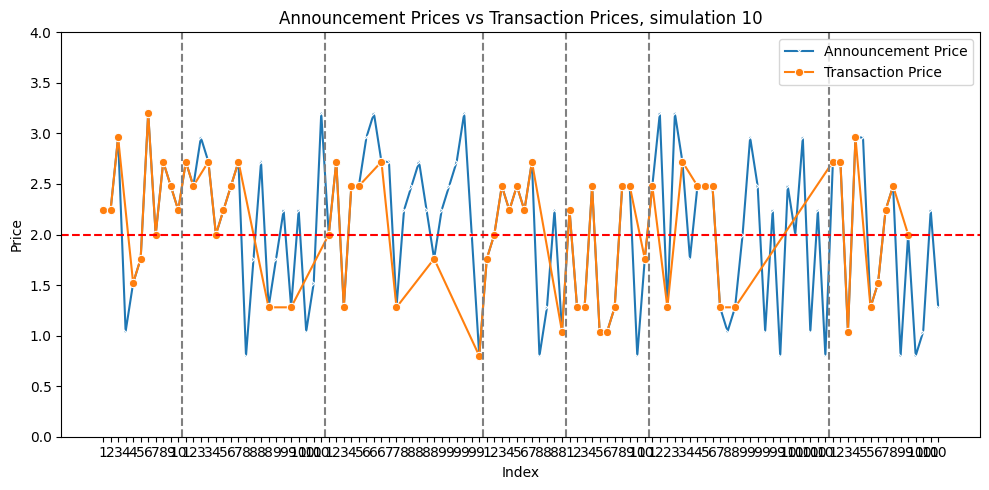

In [42]:
sim = 10
df_plot = df_announcements.loc[df_announcements['sim']==sim]

plt.figure(figsize=(10, 5))

# --- Line 1: full data ---
sns.lineplot(
    x=df_plot.index, 
    y='price', 
    data=df_plot, 
    marker='x', 
    label='Announcement Price'
)

# --- Line 2: filtered subset ---
condition = df_plot['transaction'] == True
df_cond = df_plot[condition]

sns.lineplot(
    x=df_cond.index,
    y='price', 
    data=df_cond, 
    marker='o', 
    label='Transaction Price'
)

# --- Formatting ---
last_indices_in_round = df_plot.groupby('round')['iteration'].apply(lambda g: g.index.max())
for x in last_indices_in_round[:-1]:
    plt.axvline(x=x+0.5, color='grey', linestyle='--', linewidth=1.5)
plt.axhline(y=2, color='red', linestyle='--')
plt.xticks(ticks=df_plot.index, labels=df_plot['iteration'], rotation=0)
plt.title(f'Announcement Prices vs Transaction Prices, simulation {sim}')
plt.xlabel('Index')
plt.ylabel('Price')
plt.ylim(0, 4)
plt.legend()
plt.tight_layout()
plt.show()

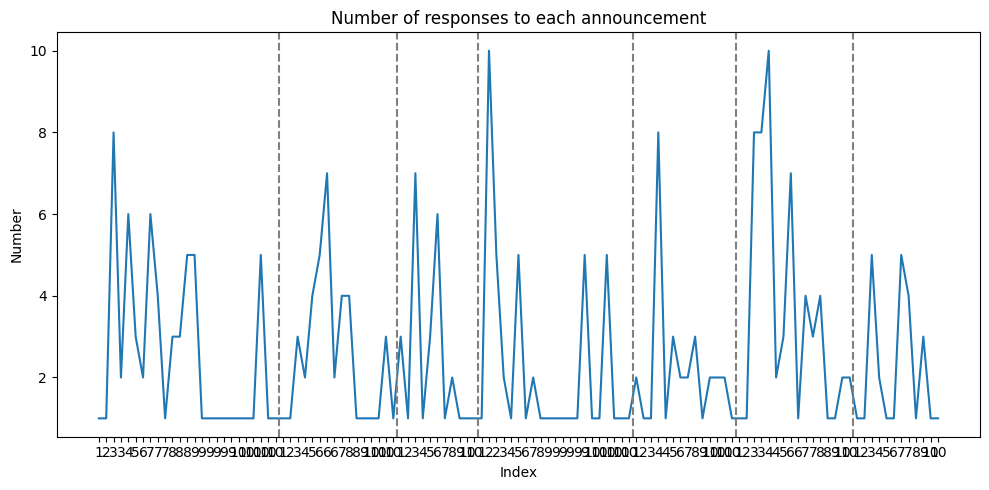

In [43]:
# plot number of responses to each announcement
sim = 8
df_plot = df_announcements.loc[df_announcements['sim']==sim]
plt.figure(figsize=(10, 5))
sns.lineplot(x=df_plot.index, y='n_responses', markers='x', 
                data=df_plot)
last_indices_in_round = df_plot.groupby('round')['iteration'].apply(lambda g: g.index.max())
for x in last_indices_in_round[:-1]:
    plt.axvline(x=x+0.5, color='grey', linestyle='--', linewidth=1.5)
plt.xticks(ticks=df_plot.index, labels=df_plot['iteration'], rotation=0)
plt.title("Number of responses to each announcement")
plt.xlabel('Index')
plt.ylabel('Number')
plt.tight_layout()
plt.show()

In [44]:
df_announcements

,sim,round,iteration,announcement_type,announcing_agent_id,price,n_responses,announcing_agent_reservation_price,transaction
0,1,1,1,sell,8,2.72,1,2.72,True
1,1,1,2,sell,5,2.72,1,2.00,True
2,1,1,3,buy,1,1.04,6,1.04,True
3,1,1,4,sell,4,1.76,1,1.76,True
4,1,1,5,buy,9,2.72,2,2.96,True
...,...,...,...,...,...,...,...,...,...
1113,10,7,9,sell,5,2.00,3,2.00,True
1114,10,7,10,buy,0,0.80,2,0.80,False
1115,10,7,10,buy,1,1.04,2,1.04,False
1116,10,7,10,sell,4,2.24,2,1.76,False


<Axes: xlabel='price', ylabel='n_responses'>

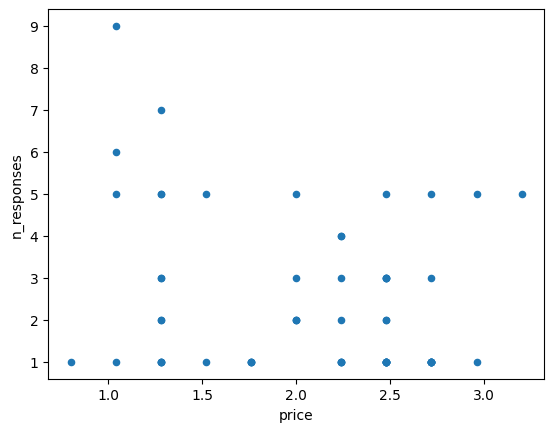

In [45]:
# correlate number of responses with price scatter plot
sim = 10
df_plot = df_announcements.loc[df_announcements['sim']==sim]
df = df_plot.loc[df_plot['transaction']==True]
df.plot.scatter(x='price', y='n_responses')
# I'd expect a u-shaped pattern



/tmp/ipykernel_14426/1172949006.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = df_plot.groupby(['sim', 'price_bin'])['n_responses'].mean().reset_index()
/tmp/ipykernel_14426/1172949006.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_bin_stats = bin_stats.groupby('price_bin')['n_responses'].mean().reset_index()


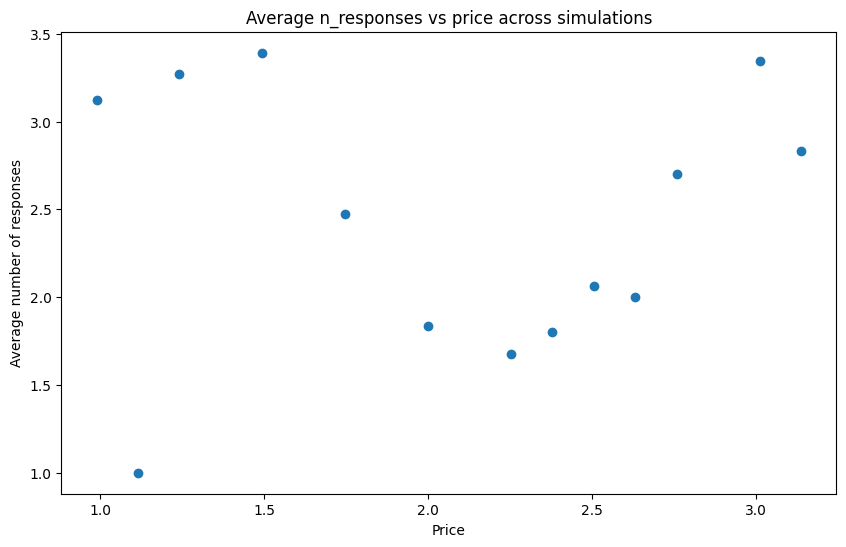

In [46]:
# Filter transaction rows
df_plot = df_announcements[df_announcements['transaction']==True].copy()

# Define price bins (optional, or just use unique prices)
bins = np.linspace(df_plot['price'].min(), df_plot['price'].max(), 20)
df_plot['price_bin'] = pd.cut(df_plot['price'], bins)

# Compute average n_responses per bin per simulation
bin_stats = df_plot.groupby(['sim', 'price_bin'])['n_responses'].mean().reset_index()

# Now average across simulations
avg_bin_stats = bin_stats.groupby('price_bin')['n_responses'].mean().reset_index()

# Plot
plt.figure(figsize=(10,6))
plt.scatter(avg_bin_stats['price_bin'].apply(lambda x: x.mid), avg_bin_stats['n_responses'])
plt.xlabel('Price')
plt.ylabel('Average number of responses')
plt.title('Average n_responses vs price across simulations')
plt.show()


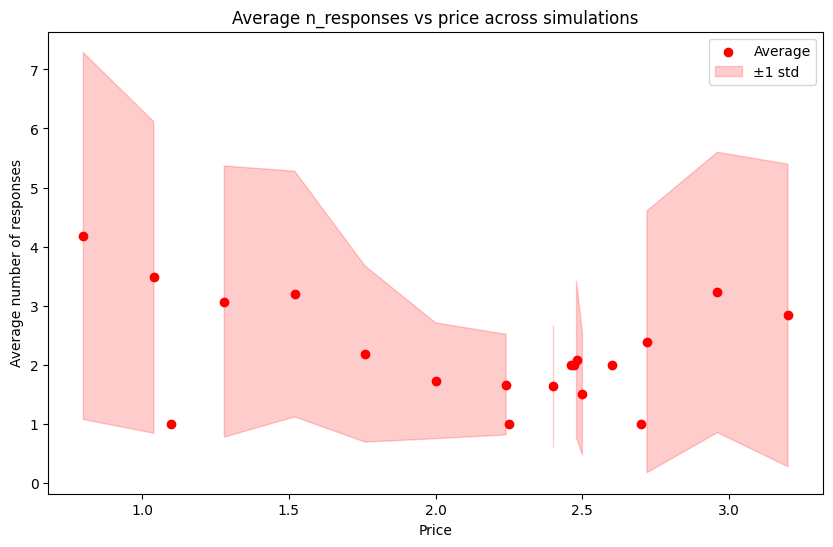

In [47]:
# Filter transactions
df_transactidf_plotons = df_announcements[df_announcements['transaction']==True].copy()

# Compute average n_responses per price across simulations
avg_price_responses = df_plot.groupby('price')['n_responses'].mean().reset_index()

# Optional: compute std for shading
std_price_responses = df_plot.groupby('price')['n_responses'].std().reset_index()

# Plot
plt.figure(figsize=(10,6))
plt.scatter(avg_price_responses['price'], avg_price_responses['n_responses'], color='red', label='Average')

# Optional: add shaded area for ±1 std
plt.fill_between(avg_price_responses['price'],
                 avg_price_responses['n_responses'] - std_price_responses['n_responses'],
                 avg_price_responses['n_responses'] + std_price_responses['n_responses'],
                 color='red', alpha=0.2, label='±1 std')

plt.xlabel('Price')
plt.ylabel('Average number of responses')
plt.title('Average n_responses vs price across simulations')
plt.legend()
plt.show()


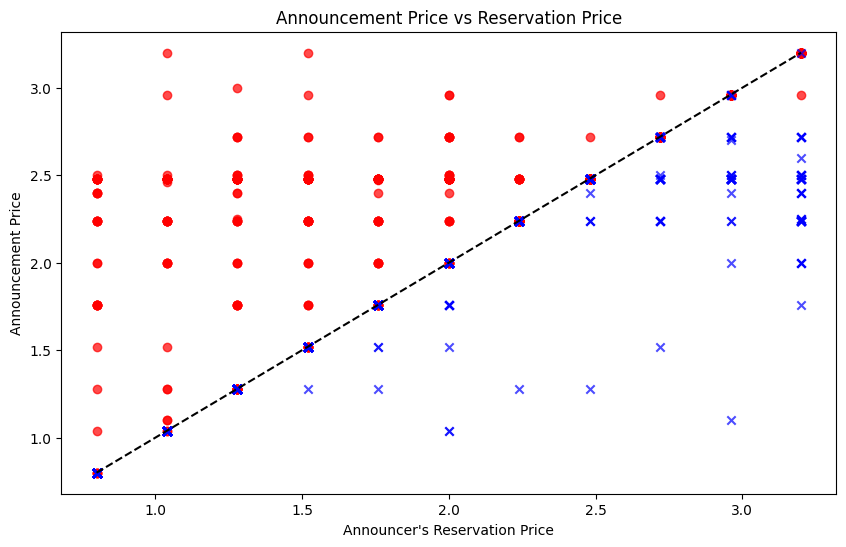

In [ ]:
# plot announcements against reservations prices
buy_mask = df_announcements['announcement_type']=='buy'
sell_mask = df_announcements['announcement_type']=='sell'

df_plot = df_announcements.loc[buy_mask]
plt.figure(figsize=(10,6))

# sellers
plt.scatter(
    df_announcements.loc[sell_mask, 'announcing_agent_reservation_price'],
    df_announcements.loc[sell_mask, 'price'],
    color='red', label='Sellers', alpha=0.7, marker='o'
)

# buyers
plt.scatter(
    df_announcements.loc[buy_mask, 'announcing_agent_reservation_price'],
    df_announcements.loc[buy_mask, 'price'],
    color='blue', label='Buyers', alpha=0.7, marker='x'
)

# add 45-degree line (y = x)
min_val = min(df_announcements['announcing_agent_reservation_price'].min(),
              df_announcements['price'].min())
max_val = max(df_announcements['announcing_agent_reservation_price'].max(),
              df_announcements['price'].max())

plt.plot([min_val, max_val], [min_val, max_val], 'k--', label='45° Line')

plt.xlabel("Announcer's Reservation Price")
plt.ylabel('Announcement Price')
plt.title('Announcement Price vs Reservation Price')
plt.show()

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


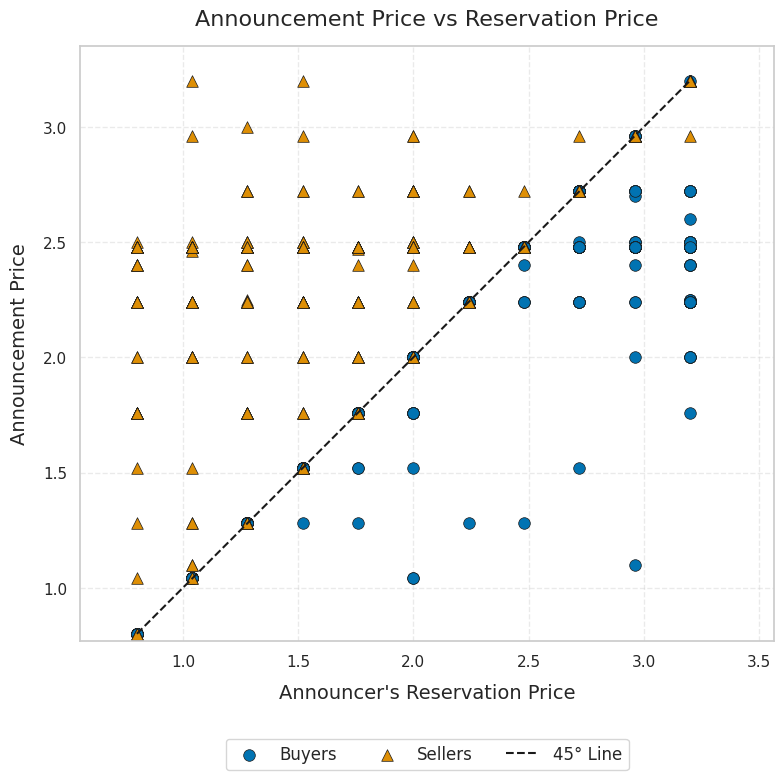

In [83]:
# Use a clean Seaborn style
sns.set_theme(style="whitegrid")

# create masks
buy_mask = df_announcements['announcement_type'] == 'buy'
sell_mask = df_announcements['announcement_type'] == 'sell'

# set up figure
plt.figure(figsize=(8, 8))

# colors (colorblind-friendly)
buyer_color = sns.color_palette("colorblind")[0]  # blue
seller_color = sns.color_palette("colorblind")[1]  # orange

# scatter plots
plt.scatter(
    df_announcements.loc[buy_mask, 'announcing_agent_reservation_price'],
    df_announcements.loc[buy_mask, 'price'],
    color=buyer_color, label='Buyers', 
    edgecolor='k', s=70, linewidth=0.5, marker='o'
)

plt.scatter(
    df_announcements.loc[sell_mask, 'announcing_agent_reservation_price'],
    df_announcements.loc[sell_mask, 'price'],
    color=seller_color, label='Sellers',
    edgecolor='k', s=70, linewidth=0.5, marker='^'
)

# 45-degree line
min_val = min(df_announcements['announcing_agent_reservation_price'].min(),
              df_announcements['price'].min())
max_val = max(df_announcements['announcing_agent_reservation_price'].max(),
              df_announcements['price'].max())

plt.plot([min_val, max_val], [min_val, max_val],
         'k--', linewidth=1.5, label='45° Line')

# labels and formatting
plt.xlabel("Announcer's Reservation Price", fontsize=14, labelpad=10)
plt.ylabel("Announcement Price", fontsize=14, labelpad=10)
plt.title("Announcement Price vs Reservation Price", fontsize=16, pad=15)
plt.legend(frameon=True, fontsize=12)
plt.grid(True, linestyle='--', alpha=0.4)

# make axes square (for true 45° comparison)
plt.axis('equal')

# slightly extend limits
plt.xlim(min_val * 0.95, max_val * 1.05)
plt.ylim(min_val * 0.95, max_val * 1.05)

# tighten layout
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=12, frameon=True)
plt.tight_layout()

# export high-quality version
# plt.savefig("announcement_price_vs_reservation_price.png", dpi=300, bbox_inches='tight')
plt.show()


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


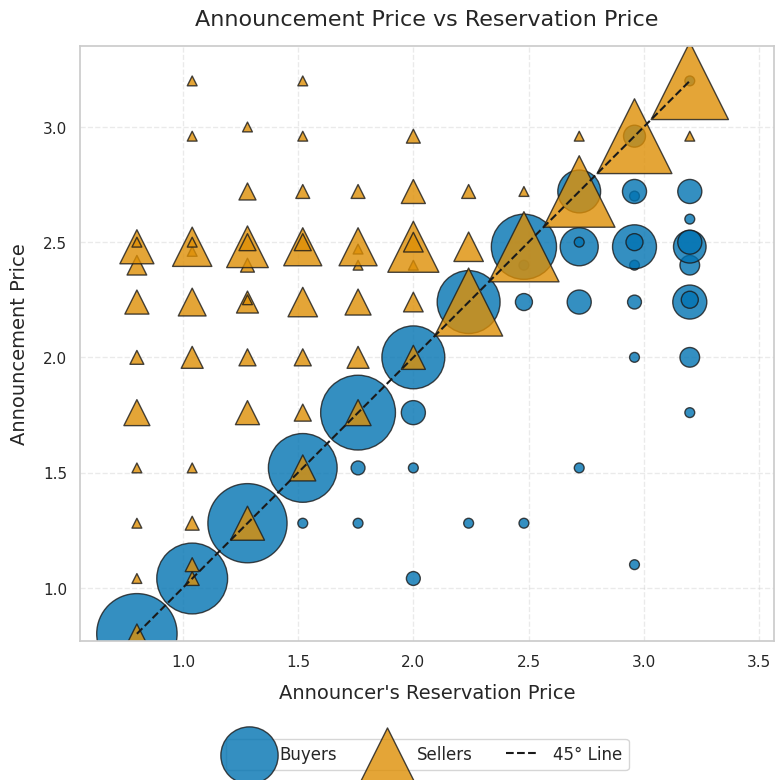

In [84]:
# Count occurrences of each (x, y) pair
counts = df_announcements.groupby(
    ['announcing_agent_reservation_price', 'price', 'announcement_type']
).size().reset_index(name='count')

# scale counts to marker size (adjust factor as needed)
counts['marker_size'] = counts['count'] * 50

# Use a clean Seaborn style
sns.set_theme(style="whitegrid")

# separate buyers and sellers
buyers = counts[counts['announcement_type'] == 'buy']
sellers = counts[counts['announcement_type'] == 'sell']

# set up figure
plt.figure(figsize=(8, 8))

# colors (colorblind-friendly)
buyer_color = sns.color_palette("colorblind")[0]  # blue
seller_color = sns.color_palette("colorblind")[1]  # orange

# scatter plots
plt.scatter(
    buyers['announcing_agent_reservation_price'],
    buyers['price'],
    s=buyers['marker_size'],  # size proportional to count
    color=buyer_color,
    marker='o', edgecolor='k', label='Buyers', alpha=0.8
)

plt.scatter(
    sellers['announcing_agent_reservation_price'],
    sellers['price'],
    s=sellers['marker_size'],
    color=seller_color,
    marker='^', edgecolor='k', label='Sellers', alpha=0.8
)

# 45-degree line
min_val = min(df_announcements['announcing_agent_reservation_price'].min(),
              df_announcements['price'].min())
max_val = max(df_announcements['announcing_agent_reservation_price'].max(),
              df_announcements['price'].max())

plt.plot([min_val, max_val], [min_val, max_val],
         'k--', linewidth=1.5, label='45° Line')

# labels and formatting
plt.xlabel("Announcer's Reservation Price", fontsize=14, labelpad=10)
plt.ylabel("Announcement Price", fontsize=14, labelpad=10)
plt.title("Announcement Price vs Reservation Price", fontsize=16, pad=15)
plt.legend(frameon=True, fontsize=12)
plt.grid(True, linestyle='--', alpha=0.4)

# make axes square (for true 45° comparison)
plt.axis('equal')

# slightly extend limits
plt.xlim(min_val * 0.95, max_val * 1.05)
plt.ylim(min_val * 0.95, max_val * 1.05)

# tighten layout
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=12, frameon=True)
plt.tight_layout()

# export high-quality version
# plt.savefig("announcement_price_vs_reservation_price.png", dpi=300, bbox_inches='tight')
plt.show()


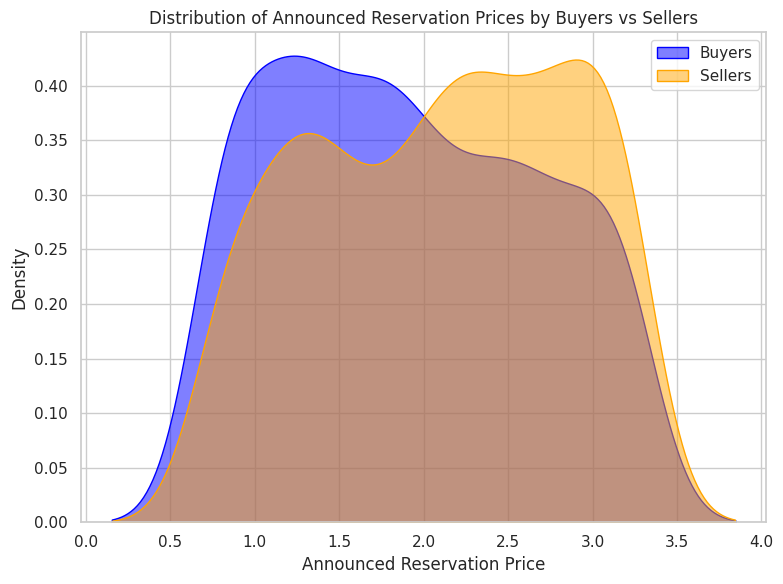

In [98]:
plt.figure(figsize=(8,6))
sns.kdeplot(
    df_announcements.loc[buy_mask, 'announcing_agent_reservation_price'],
    label='Buyers', color='blue', fill=True, alpha=0.5
)
sns.kdeplot(
    df_announcements.loc[sell_mask, 'announcing_agent_reservation_price'],
    label='Sellers', color='orange', fill=True, alpha=0.5
)

plt.xlabel("Announced Reservation Price")
plt.ylabel("Density")
plt.title("Distribution of Announced Reservation Prices by Buyers vs Sellers")
plt.legend()
plt.tight_layout()
plt.show()


/tmp/ipykernel_14426/3809186979.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


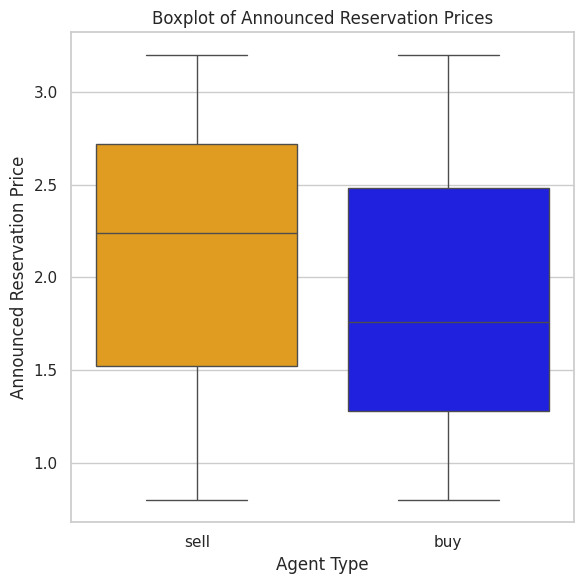

In [88]:
plt.figure(figsize=(6,6))
sns.boxplot(
    x='announcement_type',
    y='announcing_agent_reservation_price',
    data=df_announcements,
    palette={'buy':'blue', 'sell':'orange'}
)
plt.xlabel("Agent Type")
plt.ylabel("Announced Reservation Price")
plt.title("Boxplot of Announced Reservation Prices")
plt.tight_layout()
plt.show()


/tmp/ipykernel_14426/2401553270.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


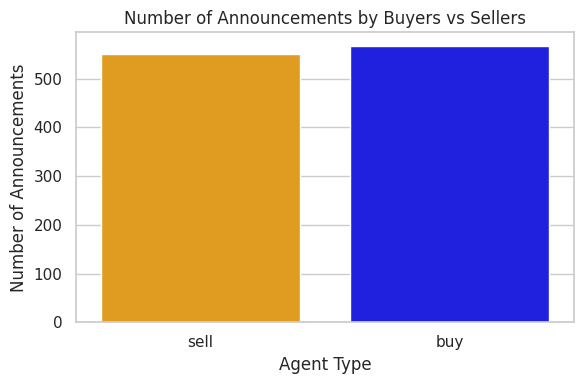

In [89]:
plt.figure(figsize=(6,4))
sns.countplot(
    x='announcement_type',
    data=df_announcements,
    palette={'buy':'blue', 'sell':'orange'}
)
plt.ylabel("Number of Announcements")
plt.xlabel("Agent Type")
plt.title("Number of Announcements by Buyers vs Sellers")
plt.tight_layout()
plt.show()


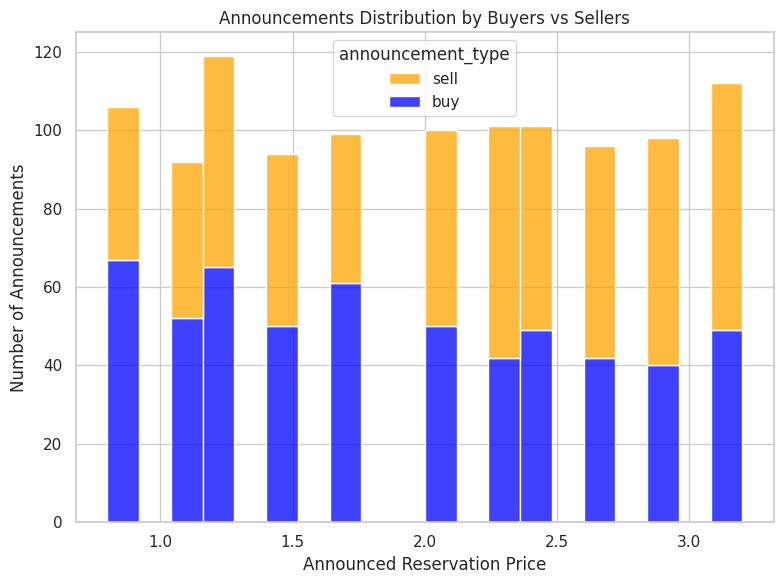

In [90]:
plt.figure(figsize=(8,6))
sns.histplot(
    data=df_announcements,
    x='announcing_agent_reservation_price',
    hue='announcement_type',
    multiple='stack',  # stacked bars per bin
    palette={'buy':'blue', 'sell':'orange'},
    bins=20
)
plt.xlabel("Announced Reservation Price")
plt.ylabel("Number of Announcements")
plt.title("Announcements Distribution by Buyers vs Sellers")
plt.tight_layout()
plt.show()


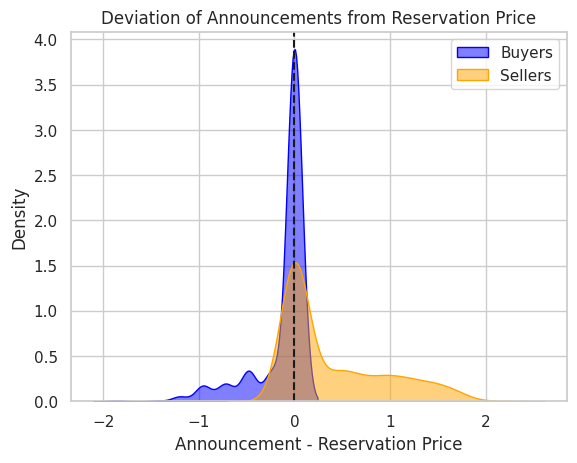

In [91]:
df_plot = df_announcements.copy()
df_plot['deviation'] = df_plot['price'] - df_plot['announcing_agent_reservation_price']


sns.kdeplot(df_plot.loc[buy_mask, 'deviation'], label='Buyers', color='blue', fill=True, alpha=0.5)
sns.kdeplot(df_plot.loc[sell_mask, 'deviation'], label='Sellers', color='orange', fill=True, alpha=0.5)
plt.axvline(0, color='k', linestyle='--')  # zero deviation
plt.xlabel("Announcement - Reservation Price")
plt.ylabel("Density")
plt.title("Deviation of Announcements from Reservation Price")
plt.legend()
plt.show()


### Profit Charts

In [118]:
len(df_profits['seller_profit'].unique())

40

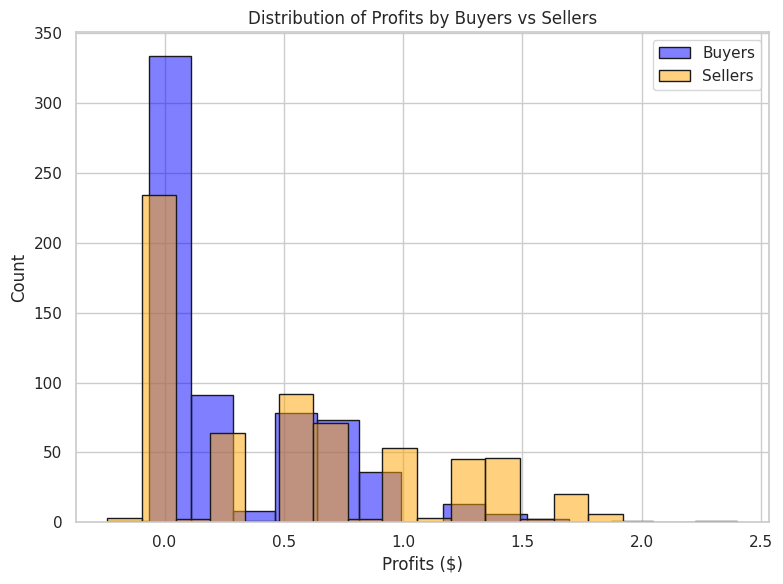

In [124]:
# compare profit distributions between buyers and sellers
plt.figure(figsize=(8,6))

# Buyers
sns.histplot(
    df_profits["buyer_profit"],
    color='blue',
    label='Buyers',
    bins=15,
    alpha=0.5,
    edgecolor='k'
)

# Sellers
sns.histplot(
    df_profits['seller_profit'],
    color='orange',
    label='Sellers',
    bins=15,
    alpha=0.5,
    edgecolor='k'
)

plt.xlabel("Profits ($)")
plt.ylabel("Count")
plt.title("Distribution of Profits by Buyers vs Sellers")
plt.legend()
plt.tight_layout()
plt.show()

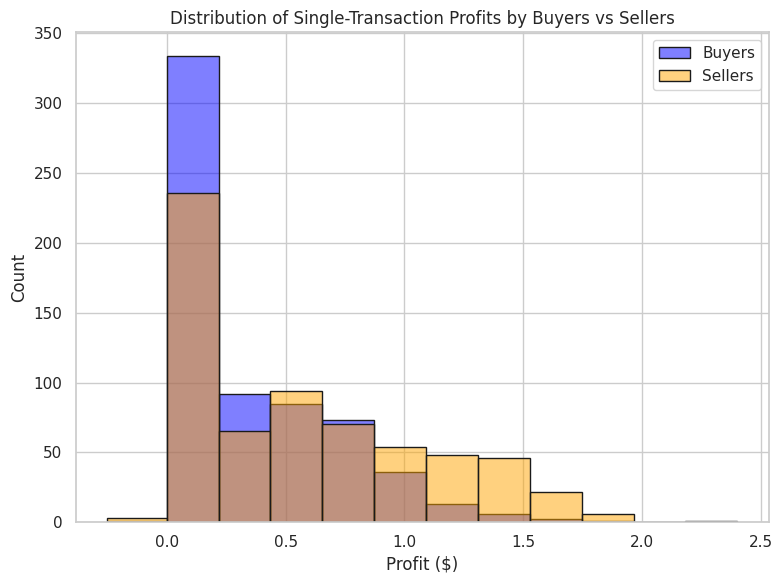

In [142]:
# Define bin edges
min_profit = df_profits[['buyer_profit','seller_profit']].min().min()
max_profit = df_profits[['buyer_profit','seller_profit']].max().max()

# Bins: negative, zero, then multiple positive bins
positive_bins = np.linspace(0, max_profit, 12)  # adjust 14 for number of positive bins
bins = np.concatenate(([min_profit-0.01, 0], positive_bins[1:]))

plt.figure(figsize=(8,6))

# Buyers
sns.histplot(
    df_profits["buyer_profit"],
    color='blue',
    label='Buyers',
    bins=bins,
    alpha=0.5,
    edgecolor='k'
)

# Sellers
sns.histplot(
    df_profits['seller_profit'],
    color='orange',
    label='Sellers',
    bins=bins,
    alpha=0.5,
    edgecolor='k'
)

plt.xlabel("Profit ($)")
plt.ylabel("Count")
plt.title("Distribution of Single-Transaction Profits by Buyers vs Sellers")
plt.legend()
plt.tight_layout()
plt.show()
